# Coding Temple's Data Analytics Program:
---
## Python for DA: Machine Learning Assignment

For your assignment today, you will look through the [UCI Irvine ML Repository](https://archive.ics.uci.edu/datasets) to find a dataset that you can build a model on. Your workflow should look something like:

- Import any necessary libraries
- Load in the data
- Clean/Tidy the Data
- Explore the data:
    - Gather all summary statistics
    - Visualize your data and your target
    - Identify any relationships between your target and the feature matrix
    - Loop back through and continue cleaning data/feature engineering as needed
- Split the data
- Establish a baseline model
- Create model
- Establish model accuracy
- Hypertune your model
- Communicate your results

The model, data, and methods you use are all completely up to you for this assignment! Ensure you label your notebook with markdown cells and proper comments

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, XGBRegressor

import numpy as np


In [189]:
penguin_url = r'https://raw.githubusercontent.com/mcnakhaee/palmerpenguins/master/palmerpenguins/data/penguins-raw.csv'
def firm_penguin(filepath):
    df = pd.read_csv(penguin_url)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.drop('stage',inplace=True,axis=1) #Only one stage type is found in the data
    df.drop('comments',inplace=True,axis=1) #blurb of information not needed
    df.drop('delta_13_c_(o/oo)',inplace=True,axis=1)
    df.drop('delta_15_n_(o/oo)',inplace=True,axis=1)
    df.rename(columns={'studyname':'study_name'},inplace=True)
    
    df.drop('study_name',inplace=True,axis=1) #unique identifiers being removed after heatmap
    df.drop('sample_number',inplace=True,axis=1)
    df.drop('individual_id',inplace=True,axis=1)
    df.drop('region',inplace=True,axis=1) # There's only one region
    df.drop('clutch_completion',inplace=True,axis=1)
    df.drop('date_egg',inplace=True,axis=1) 
    return df

def null_huh(clean_df):
    """
    A code block pulled from Tuesday's homework and retrofitted into a function.
    This function's purpose is to iterate through a Pandas DataFrame and return
    a dictionary with keys telling you the amount of null values and non null values.
    """
    null_check = [{'nonull':0},{'isnull':0}]
    for names in clean_df.columns.tolist():
        for i in range(len(clean_df[names])):
            if pd.isnull(clean_df[names][i]):
                null_check[1]['isnull'] += 1
            else:
                null_check[0]['nonull'] += 1
    return null_check




pdf = firm_penguin(penguin_url)
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   species              344 non-null    object 
 1   island               344 non-null    object 
 2   culmen_length_(mm)   342 non-null    float64
 3   culmen_depth_(mm)    342 non-null    float64
 4   flipper_length_(mm)  342 non-null    float64
 5   body_mass_(g)        342 non-null    float64
 6   sex                  333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [190]:
pdf = pdf.sort_values('culmen_length_(mm)').reset_index(drop=True) #cleaning null values
pdf = pdf[:-2]
pdf = pdf.sort_values('sex').reset_index(drop=True)
pdf = pdf[:-9]
pdf.sex = pdf.sex.str.lower()
print(null_huh(pdf)) #Checking for null values
# pdf.sort_values('date_egg').head(20)

[{'nonull': 2331}, {'isnull': 0}]


In [191]:
gender_dis = px.bar(pdf['sex'],title='Distribution of Gender',color=pdf['species'])
gender_dis.update_xaxes(title='sex')
gender_dis.show()
sex_check = [{'female':0},{'male':0}]
for i in range(len(pdf['sex'])):
    if (pdf['sex'][i]) == 'female':
        sex_check[0]['female'] += 1
    else:
        sex_check[1]['male'] += 1
sex_check.append({'disparity': (abs(int(sex_check[1]['male']) - int(sex_check[0]['female'])))})
sex_check


[{'female': 165}, {'male': 168}, {'disparity': 3}]

This is to look at the distribution of gender in the data of penguins. There is a tiny disparity between the two of about 3. Looking at the graph, this increase seems to be mainly in registered
in the Adelie Penguin species.

Going forward, I'm going to be using classification analysis to see if a model can predict the species by attributes such as the culmin length, culmin width, flipper length, and body mass.

When making the baseline, the majority Adelie species will be used as the baseline.

In [192]:
# after inspecting this heat map, I realized I didn't need sample size nor any unique identifying information for each individual penguin for the model to see. So I will be dropping those columns.
corr_pdf = px.imshow(pdf.corr(numeric_only=True))
corr_pdf.show()

In [193]:
linear_beak = px.scatter(pdf, x ='culmen_length_(mm)', y='culmen_depth_(mm)',color='species',title='Linearity of Beak Length Across Species and Gender',facet_col="island",facet_row='sex')
linear_beak.show()

Checking to see the linearity of beak lengths for each species, there might be some issues with the model with the two outliers. These being the male length and width 59.6 mm 17 mm respectively, and the
female length and width 58 mm 17.8 mm respectively. However, I'm going to be leaving them in. If my prediction model is having accuracy issues they will then be taken out.

In [194]:
# Dropping the island column and sex column cause its screwing up with making the pipeline.
# pdf.drop('island', axis=1, inplace=True)
# Figured it out
pdf

,species,island,culmen_length_(mm),culmen_depth_(mm),flipper_length_(mm),body_mass_(g),sex
0,Adelie Penguin (Pygoscelis adeliae),Dream,32.1,15.5,188.0,3050.0,female
1,Gentoo penguin (Pygoscelis papua),Biscoe,44.0,13.6,208.0,4350.0,female
2,Chinstrap penguin (Pygoscelis antarctica),Dream,58.0,17.8,181.0,3700.0,female
3,Gentoo penguin (Pygoscelis papua),Biscoe,44.9,13.3,213.0,5100.0,female
4,Gentoo penguin (Pygoscelis papua),Biscoe,44.9,13.8,212.0,4750.0,female
...,...,...,...,...,...,...,...
328,Adelie Penguin (Pygoscelis adeliae),Dream,37.8,18.1,193.0,3750.0,male
329,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.8,20.0,190.0,4250.0,male
330,Gentoo penguin (Pygoscelis papua),Biscoe,45.5,15.0,220.0,5000.0,male
331,Adelie Penguin (Pygoscelis adeliae),Dream,39.2,21.1,196.0,4150.0,male


In [195]:
target = 'species'

X = pdf.drop('species', axis=1)
y = pdf[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=.8)

assert len(x_train) + len(x_test) == len(X), 'Data did not properly split' # Copied from notes

In [196]:
baseline = round(max(pdf.species.value_counts(normalize=True)) *100,2)

# print(pdf.species.value_counts())
# print(baseline)

In [218]:
linear_regress = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(max_iter=1500) #absolutely annoying getting this number, if its one less. It'll give back an error
) #960 for OneHotEncoder, 788 for OrdinalEncoder. Set it to 1500 to get rid of it on tuning step.

linear_regress.fit(x_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['island', 'sex'],
                                mapping=[{'col': 'island',
                                          'data_type': dtype('O'),
                                          'mapping': Biscoe       1
Dream        2
Torgersen    3
NaN         -2
dtype: int64},
                                         {'col': 'sex', 'data_type': dtype('O'),
                                          'mapping': female    1
male      2
NaN      -2
dtype: int64}])),
                ('logisticregression', LogisticRegression(max_iter=1500))])

In [198]:
decision_tree = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier()
)

decision_tree.fit(x_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['island', 'sex'], use_cat_names=True)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [199]:
ran_forest = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier()
)

ran_forest.fit(x_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['island', 'sex'], use_cat_names=True)),
                ('randomforestclassifier', RandomForestClassifier())])

In [200]:
xgb_pipe = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(objective='binary:logistic')
)

xgb_pipe.fit(x_train,LabelEncoder().fit_transform(y_train))

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['island', 'sex'])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [232]:
print('Logistic Regression:')
print(f'Training Accuracy: {round(linear_regress.score(x_train, y_train),2)*100}')
print(f'Testing Accuracy: {round(linear_regress.score(x_test, y_test),2)*100}')
print('---------------------')
print('Decision Tree Classifier:')
print(f'Training Accuracy: {round(decision_tree.score(x_train, y_train), 2)*100}')
print(f'Testing Accuracy: {round(decision_tree.score(x_test, y_test), 2)*100}')
print('---------------------')
print('Random Forest Classifier:')
print(f'Training Accuracy: {round(ran_forest.score(x_train, y_train), 2)*100}')
print(f'Testing Accuracy: {round(ran_forest.score(x_test, y_test), 2) * 100}')
print('---------------------')
print('XGBoost Classifier:')
print(f'Training Accuracy: {round(xgb_pipe.score(x_train, y_train), 2)*100}')
print(f'Testing Accuracy: {round(xgb_pipe.score(x_test, y_test), 2) * 100}')

Logistic Regression:
Training Accuracy: 100.0
Testing Accuracy: 97.0
---------------------
Decision Tree Classifier:
Training Accuracy: 100.0
Testing Accuracy: 97.0
---------------------
Random Forest Classifier:
Training Accuracy: 100.0
Testing Accuracy: 100.0
---------------------
XGBoost Classifier:
Training Accuracy: 0.0
Testing Accuracy: 0.0


Looking at all the models, the Random Forest Classifier was the most accurate. Honestly I have no idea if the xgboost classifier is working.Going back through notes shows it being 0 for those scores as well. 

In [231]:
print("Logistic Regression:")
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, linear_regress.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, linear_regress.predict_proba(x_test), multi_class="ovr"),2)*100}')
print('-------------------------------')
print('Decision Tree Classifier:')
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, decision_tree.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, decision_tree.predict_proba(x_test), multi_class="ovr"),2)*100}')
print('-------------------------------')
print('Random Forest Classifier:')
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, ran_forest.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, ran_forest.predict_proba(x_test), multi_class="ovr"),2)*100}')
print('------------------------------')
print('XGBoost Classifier:')
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, xgb_pipe.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, xgb_pipe.predict_proba(x_test), multi_class="ovr"),2)*100}')

Logistic Regression:
Training ROC AUC Score: 100.0
Testing ROC AUC Score: 100.0
-------------------------------
Decision Tree Classifier:
Training ROC AUC Score: 100.0
Testing ROC AUC Score: 97.0
-------------------------------
Random Forest Classifier:
Training ROC AUC Score: 100.0
Testing ROC AUC Score: 100.0
------------------------------
XGBoost Classifier:
Training ROC AUC Score: 100.0
Testing ROC AUC Score: 100.0


The efficiency or ROC AUC score of each model is perfect except for the decision tree model. I am curious to know if that is because of the encoder.

In [203]:
decision_tree22 = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier()
)

decision_tree22.fit(x_train,y_train)

print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, decision_tree.predict_proba(x_test), multi_class="ovr"),2)*100}')

Testing ROC AUC Score: 97.0


Came out to the same.

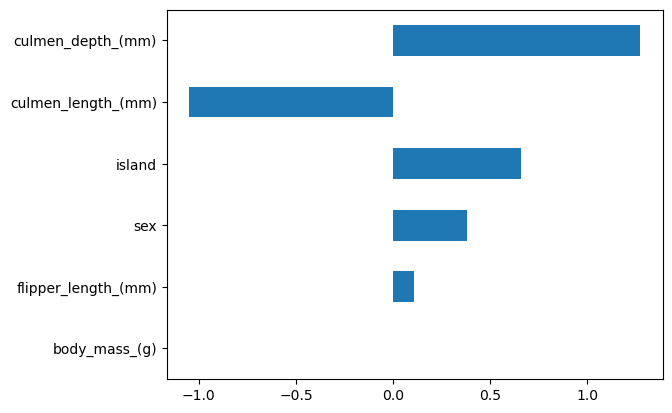

In [204]:
coefficients = linear_regress.named_steps['logisticregression'].coef_
features = linear_regress.feature_names_in_
# print(len(features))
# print(len(coefficients))

feat_imp = pd.Series(coefficients[0], index=features).sort_values(key=abs) #Originally would not work with using OneHotEncoder. Had to switch it to Ordinal
feat_imp.plot(kind='barh',)
plt.show()

It appears that the body mass was completely unused in the decision making of the model. Interestingly, I was expecting the length to be biggest factor for decision making of the model, but it was the depth of the beak. Going forward, It appears that the beak depth and beak length are incredibly advantageous and key to identifying penguin species in the Anvers region.

In [219]:
param_grid = {
    'logisticregression__C': np.arange(0.1,2.,.2) # dunder not single underscore in the key. spent 10 minutes trying to figure that error out
}

pclf = RandomizedSearchCV(linear_regress, param_grid,)
pclf.fit(x_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['island',
                                                                   'sex'],
                                                             mapping=[{'col': 'island',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Biscoe       1
Dream        2
Torgersen    3
NaN         -2
dtype: int64},
                                                                      {'col': 'sex',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': female    1
male      2
NaN      -2
dtype: int64}])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1500))]),
                   param_distributions={'logisticregression__C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])})

In [230]:
print(pclf.best_score_)
print(pclf.best_params_)

linear_regress_tuned = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(max_iter=1500, C=0.30000000000000004)
)
linear_regress_tuned.fit(x_train,y_train)

print(f'Training Accuracy: {round(linear_regress_tuned.score(x_train, y_train),2)*100}')
print(f'Testing Accuracy: {round(linear_regress_tuned.score(x_test, y_test),2)*100}')
print('-----------------------')
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, linear_regress_tuned.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, linear_regress_tuned.predict_proba(x_test), multi_class="ovr"),2)*100}')


0.9924528301886791
{'logisticregression__C': 0.30000000000000004}
Training Accuracy: 100.0
Testing Accuracy: 97.0
-----------------------
Training ROC AUC Score: 100.0
Testing ROC AUC Score: 100.0


Fine tuning the linear regression model didn't seem to improve accuracy test. After going back and reviewing notes, I'm not quite sure where to use the baseline. Will have to ask for clarification later.